In [21]:
%load_ext autoreload
%autoreload 2
from scaleagdata_vito.presto.datasets_prometheo import ScaleAgInferenceDataset
from pathlib import Path
import xarray as xr
from prometheo.models.presto.wrapper import PretrainedPrestoWrapper, load_pretrained
from prometheo.predictors import collate_fn
from scaleagdata_vito.presto.datasets_prometheo import InferenceDataset
from typing import Literal
import torch
from torch.utils.data import DataLoader
from torch import nn
from einops import rearrange
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### test

In [5]:
path_to_file = Path('/home/giorgia/Private/git/worldcereal-classification/tests/worldcerealtests/testresources/worldcereal_preprocessed_inputs.nc')
cl = ScaleAgInferenceDataset(compositing_window="month")
s1, s2, meteo, dem, latlon, timestamps = cl.nc_to_array(path_to_file)
s1.shape, s2.shape, meteo.shape, dem.shape, latlon.shape, timestamps.shape

((10000, 1, 1, 12, 2),
 (10000, 1, 1, 12, 13),
 (10000, 12, 2),
 (10000, 1, 1, 2),
 (10000, 2),
 (10000, 12, 3))

In [ ]:
class PrestoPredictor:
    def __init__(self,
                model: PretrainedPrestoWrapper, 
                batch_size: int = 8192,
                task_type: Literal["regression", "binary", "multiclass"] = "regression",
                compositing_window: Literal["dekad", "month"] = "dekad"):
        """
        Initialize the PrestoFeatureExtractor with a Presto model.

        Args:
            model (Presto): The Presto model used for feature extraction.
            batch_size (int): Batch size for dataloader.
        """
        self.model = model.to(device="cuda" if torch.cuda.is_available() else "cpu")
        self.batch_size = batch_size
        self.task_type = task_type
        self.compositing_window = compositing_window

    def predict(self, path_to_file: Path) -> xr.DataArray:
        cl = ScaleAgInferenceDataset(compositing_window=self.compositing_window)
        s1_cube, s2_cube, meteo_cube, dem_cube, latlon_cube, timestamps_cube = cl.nc_to_array(path_to_file)
        ds = InferenceDataset(s1_cube, 
                              s2_cube,
                              meteo_cube,
                              dem_cube,
                              latlon_cube, 
                              timestamps_cube)
        dl = DataLoader(
            ds, 
            batch_size=self.batch_size, 
            shuffle=False, 
            collate_fn=collate_fn
        )

        all_preds, all_probs = [], []
        self.model.eval()
        for batch in dl:
            with torch.no_grad():
                output = self.model(batch, inference=True)
                # binary classification
                if self.task_type == "binary":
                    probs = torch.sigmoid(output).cpu().numpy() 
                    preds = probs > 0.5                     
                # multiclass classification
                elif self.task_type == "multiclass":
                    probs = torch.softmax(output, dim=-1).cpu().numpy()
                    preds = probs.argmax(dim=-1)
                
                all_preds.append(preds.flatten())
                all_probs.append(probs.flatten())
        
        # need to be reshaped 
        all_preds = np.concatenate(all_preds)
        all_probs = np.concatenate(all_probs)
        return all_preds, all_probs

In [ ]:

# presto_url="https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal/models/PhaseII/presto-ss-wc_longparquet_random-window-cut_no-time-token_epoch96.pt"
presto_url="https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal/models/PhaseII/presto-ss-wc-ft-ct_cropland_CROPLAND2_30D_random_time-token%3Dnone_balance%3DTrue_augment%3DTrue.pt"
# presto_url = "/home/giorgia/Private/git/scaleag-vito/presto-prometheo-binary-CROPLAND2-timeexplicit=False-run=202504161049.pt"
task_type = "binary" # "regression", "binary", "multiclass"
num_outputs = 14
if task_type == "regression":
    finetuned_model = PretrainedPrestoWrapper(num_outputs=1, regression=True)
elif task_type == "binary":
    # finetuned_model = PretrainedPrestoWrapper(num_outputs=1, regression=False) #, pretrained_model_path=presto_url)
    finetuned_model = PretrainedPrestoWrapper(num_outputs=1, regression=False, pretrained_model_path=presto_url)
elif task_type == "multiclass":
    finetuned_model = PretrainedPrestoWrapper(num_outputs=num_outputs, regression=False)

# finetuned_model = load_pretrained( finetuned_model, presto_url) # here strict is True 
presto_model = PrestoPredictor(
    model=finetuned_model,
    batch_size=50,
    task_type=task_type,
    compositing_window="month",
)

In [ ]:
path_to_file = Path('/home/giorgia/Private/git/worldcereal-classification/tests/worldcerealtests/testresources/worldcereal_preprocessed_inputs.nc')
preds, probs = presto_model.predict(path_to_file)

In [ ]:
path_to_file_target = Path('/home/giorgia/Private/git/worldcereal-classification/tests/worldcerealtests/testresources/worldcereal_cropland_classification.nc')
target_arr = xr.open_dataarray(path_to_file_target).astype('uint16')
target_pred = target_arr.sel(bands='classification').data
target_probs = target_arr.sel(bands='probability_cropland').data
input_arr = xr.load_dataset(path_to_file)
x_coords = input_arr.x.values
y_coords = input_arr.y.values
preds_map = rearrange(preds, '(y x) -> y x', y=len(y_coords), x=len(x_coords))
prob_map = rearrange(probs, '(y x) -> y x', y=len(y_coords), x=len(x_coords))
bands = ['S2-L2A-B04', 'S2-L2A-B03', 'S2-L2A-B02']
rgb = np.stack([input_arr[band].values for band in bands], axis=-1)

In [ ]:
def min_max_normalize(image):
    # Ensure the input is a numpy array
    image = np.array(image, dtype=np.float32)
    
    # Compute the minimum and maximum values for the entire image
    min_val = image.min()
    max_val = image.max()
    
    # Perform min-max normalization
    normalized_image = (image - min_val) / (max_val - min_val)
    
    return normalized_image

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 5, figsize=(15, 5))
i = 5
# Plot the B2 band
axs[0].imshow(min_max_normalize(rgb[i]))
axs[0].set_title('B2 Band')

# Plot the target_arr
axs[1].imshow(target_pred, cmap='viridis')
axs[1].set_title('Target Array')

# Plot the preds_map
axs[2].imshow(preds_map, cmap='viridis')
axs[2].set_title('Predictions Map')

# Plot the preds_map
axs[3].imshow(target_probs, cmap='viridis')
axs[3].set_title('Target Prob Map')

# Plot the prob_map
axs[4].imshow(prob_map, cmap='viridis')
axs[4].set_title('Probability Map')
cbar = fig.colorbar(axs[4].images[0], ax=axs[4], fraction=0.046, pad=0.04)
cbar.set_ticks([0, 1])
cbar.set_label('Probability')
plt.tight_layout()

### Pipeline

In [65]:
%load_ext autoreload
%autoreload 2
from scaleagdata_vito.presto.inference import PrestoPredictor, reshape_result, plot_results

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:

# presto_url="https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal/models/PhaseII/presto-ss-wc_longparquet_random-window-cut_no-time-token_epoch96.pt"
presto_url="https://artifactory.vgt.vito.be/artifactory/auxdata-public/worldcereal/models/PhaseII/presto-ss-wc-ft-ct_cropland_CROPLAND2_30D_random_time-token%3Dnone_balance%3DTrue_augment%3DTrue.pt"
# presto_url = "/home/giorgia/Private/git/scaleag-vito/presto-prometheo-binary-CROPLAND2-timeexplicit=False-run=202504161049.pt"
task_type = "binary" # "regression", "binary", "multiclass"
num_outputs = 14
if task_type == "regression":
    finetuned_model = PretrainedPrestoWrapper(num_outputs=1, regression=True)
elif task_type == "binary":
    # finetuned_model = PretrainedPrestoWrapper(num_outputs=1, regression=False) #, pretrained_model_path=presto_url)
    finetuned_model = PretrainedPrestoWrapper(num_outputs=1, regression=False, pretrained_model_path=presto_url)
elif task_type == "multiclass":
    finetuned_model = PretrainedPrestoWrapper(num_outputs=num_outputs, regression=False)

# finetuned_model = load_pretrained( finetuned_model, presto_url) # here strict is True 
presto_model = PrestoPredictor(
    model=finetuned_model,
    batch_size=50,
    task_type=task_type,
    compositing_window="month",
)

In [59]:
path_to_input_file = Path('/home/giorgia/Private/git/worldcereal-classification/tests/worldcerealtests/testresources/worldcereal_preprocessed_inputs.nc')
probs = presto_model.predict(path_to_file)
prob_map = reshape_result(probs, path_to_input_file=path_to_file)
pred_map = presto_model.get_predictions(prob_map, threshold=0.5)
# probs.min(), probs.max(), 

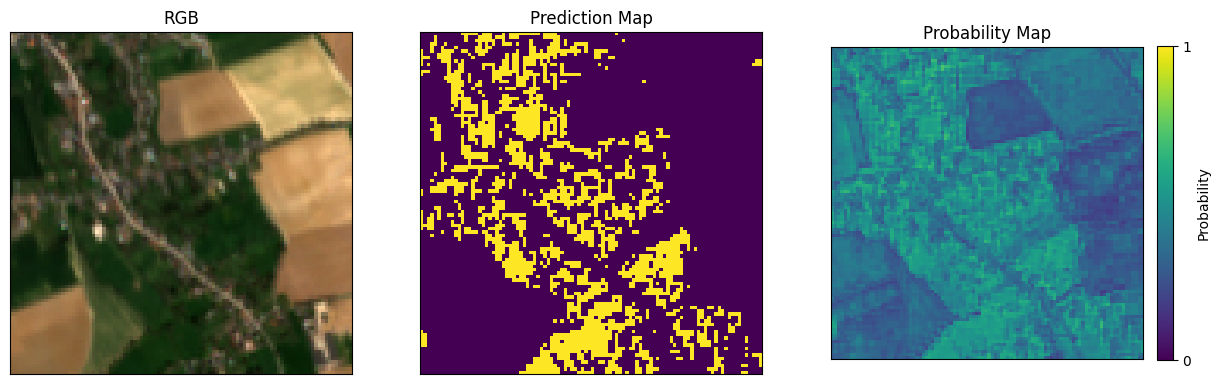

In [66]:
plot_results(prob_map=prob_map, pred_map=pred_map, path_to_input_file=path_to_input_file, ts_index=5)